In [3]:
import pandas as pd
import numpy as np
np.random.seed(2019)


import sys
import math


import scikitplot as skplt
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score

import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Airline delay

Dataset contains historical connection in US. Task is to build a model that will predict how much time lane will be delayed.

Metric to be used is Root Mean Squared Logarithmic Error (RMSLE) which tends to zero.

In [4]:
#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [6]:
train = pd.read_hdf('train_airline_delay.h5') #reading training data
test = pd.read_csv('test_airline_delay.csv') # reading test data
train.head()

,year,month,actual_departure_time,day_of_month,day_of_week,scheduled_departure_time,actual_arrival_time,scheduled_arrival_time,air_time,arrival_delay,...,distance,is_cancelled,cancellation_code,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,is_diverted,target_delay
0,0,1,943.0,17,2,947.0,1028.0,1037.0,33.0,-9.0,...,139,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
1,2,6,905.0,26,4,822.0,1026.0,932.0,117.0,54.0,...,794,False,0,43.0,0.0,11.0,0.0,0.0,False,54.0
2,1,12,1255.0,28,5,1255.0,1342.0,1344.0,25.0,-2.0,...,89,False,0,0.0,0.0,0.0,0.0,0.0,False,0.0
3,1,7,2028.0,2,1,1855.0,2136.0,1945.0,33.0,111.0,...,190,False,0,0.0,17.0,18.0,0.0,76.0,False,111.0
4,2,1,1358.0,7,1,1355.0,1437.0,1455.0,85.0,-18.0,...,590,False,0,NaN,NaN,NaN,NaN,NaN,False,0.0


Lets run a dummy model to have a benchmark for futher predictions

In [7]:
feats = ['scheduled_arrival_time']
X = train[feats].values
y = train['target_delay'].values

model = DummyRegressor(strategy='median')
model.fit(X, y)
y_pred = model.predict(X)

rmsle(y, y_pred)

2.3484998240417205

Dummy regressor returns 0 for as all predicitons and given that, we recive 2.34 as RMSLE metric.

## Data cleaning & preparation

In [8]:
# reading timezones table with data cleaning
tz = pd.read_csv('timezones_iata.csv')
tz['tz_cat'] = tz['tz'].factorize()[0]
tz_dict = dict(zip(tz.code, tz.tz_cat))

tz['tz_reg'] = tz['tz'].map(lambda x: x.split('/')[0])
tz['tz_reg_cat'] = tz['tz_reg'].factorize()[0]
tz_reg_dict = dict(zip(tz.code, tz.tz_reg_cat))

In [9]:
# lets get rid off columns from train dataset that are not present in test dataset
future_columns = []
for c in train.columns:
    if c not in test.columns:
        future_columns.append(c)

In [10]:
# Few helpful functions that will help in building new model

def get_feats(df):
    """
    input: DataFrame
    Output: DF with columns we don't want. By defualt this function will filter out future columns
    and target column so DataFrame that is being return can be put directly into a model
    """
    out = []
    feats = df.select_dtypes(include=np.number).columns
    for f in feats:
        if f not in future_columns:
            out.append(f)
    
    out = [x for x in out if x !='target_delay' and x !='target_delay_log']
    return out

def get_X(df):
    '''
    input: DataFrame
    Output: values of filtered DF
    '''
    return df[ get_feats(df) ].values

def get_y(df, target_var='target_delay'):
    '''
    input: DataFrame
    Output: values of filtered DF
    '''
    return df[target_var].values

def run_cv(model, X, y, folds=4, target_log=False,cv_type=KFold, success_metric=rmsle):
    '''
    input: model, data values and target variable.
    Function will run Cross Valuation
    '''
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train+1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred[y_pred < 0] = 0
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 #czasem może być wartość ujemna

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y+1)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        y_pred[y_pred < 0] = 0
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=3, ylim=(0, 2), target_log=False):
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buferowania

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()

In [11]:
#deleting Nan
train = train.fillna(-1)

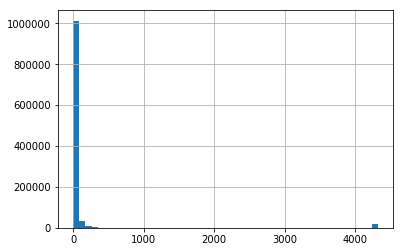

In [15]:
#Lets check distribution of target variable
train['target_delay'].hist(bins=50)

This distribution is pretty unhealthy and we can help the model by logarithmic transformation

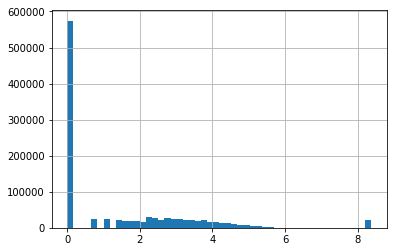

In [18]:
train['target_delay_log'] = np.log(train['target_delay'] + 1)
train['target_delay_log'].hist(bins=50)

Lets run the first training on raw data using 4 different models on 10% sample data

[dummy_median]: 1.9997482817392453 +/-0.01958350329879839


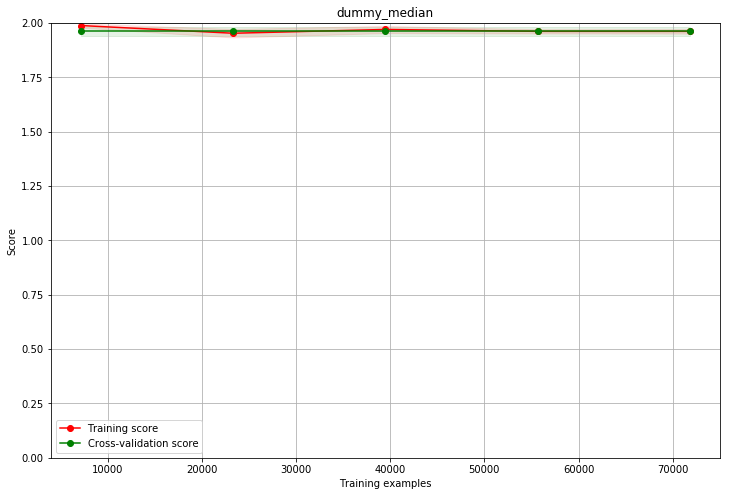

[dt]: 1.6981886674124802 +/-0.009072449211527741


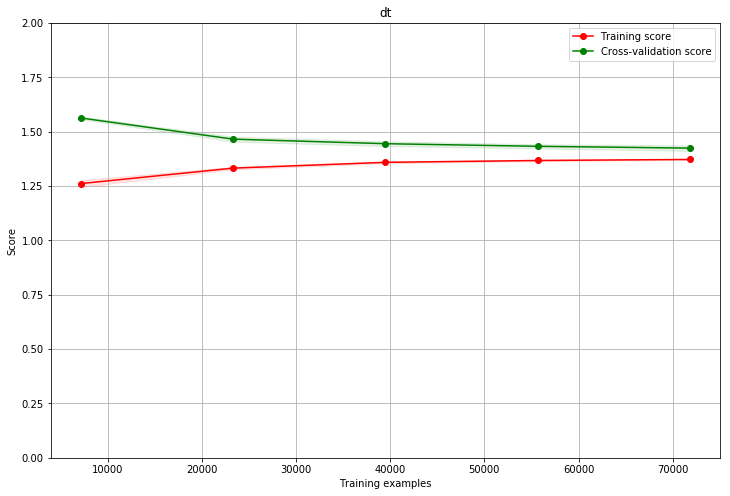

[RFR]: 1.673403372547784 +/-0.00700539566249819


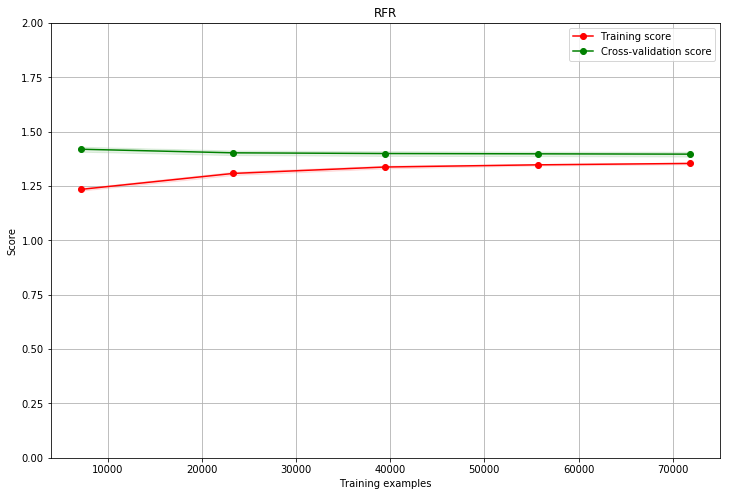

[Lgb]: 1.657900378844894 +/-0.00727570995323309


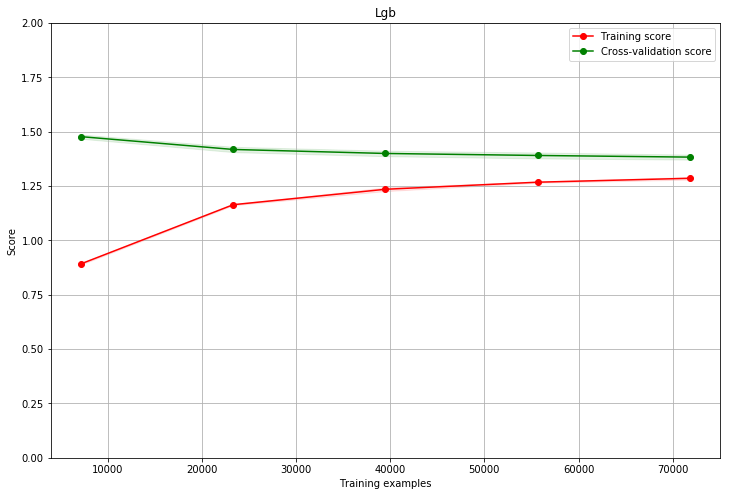

In [19]:
def get_models():
    md = 10
    ne = 100
    le=0.3
    rs = 2019
    return [
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt', DecisionTreeRegressor(max_depth=md, random_state=rs)),
        ('RFR', RandomForestRegressor(max_depth=md, n_estimators = ne, random_state=rs)),
        ('Lgb', lgb.LGBMRegressor(max_depth=md, n_estimators = ne,  learning_rate = le, random_state=rs)),
    ]

run(train.sample(frac=0.1), plot_lc=True, target_log=True)

Light booster returns the best result with healty learning curve. Result is much better then the first prediciton (2.34)

# Adding extra features which may increase the score

In [23]:
def add_columns(df):
    df['weekend'] = df['day_of_week'].map(lambda x: int(x>=6)) # If flight took place on weekend
    df['direction'] = df.apply(lambda x: '{}{}'.format(x['origin'], x['destination']), axis=1) # Possibly some connections are likely to be late
    return df

In [24]:
train = add_columns(train)

In [25]:
train['origin_cat'] = train['origin'].factorize()[0]
train['destination_cat'] = train['destination'].factorize()[0]
train['direction_cat'] = train['destination'].factorize()[0]

In [26]:
#lets check if 5 new features will improve prediciton
get_feats(train)

['year',
 'month',
 'day_of_month',
 'day_of_week',
 'scheduled_departure_time',
 'scheduled_arrival_time',
 'carrier_id',
 'flight_number',
 'tail_number',
 'scheduled_elapsed_time',
 'distance',
 'weekend',
 'origin_cat',
 'destination_cat',
 'direction_cat']

[dummy_median]: 2.0143442840793133 +/-0.001603589974619336


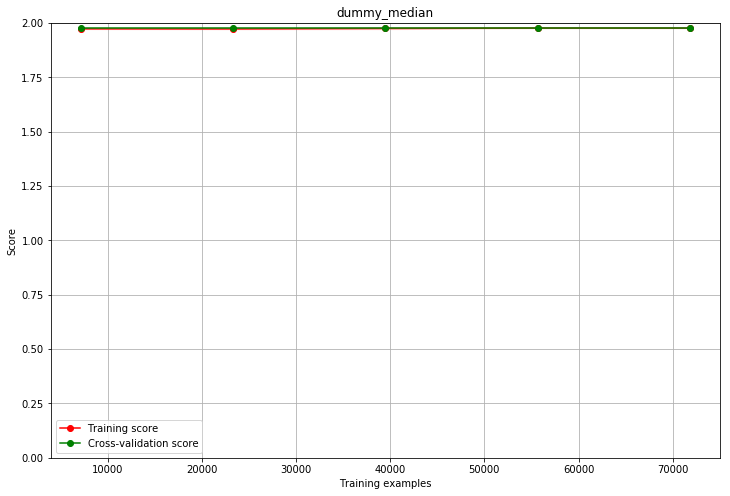

[dt]: 1.6997909737919261 +/-0.005587747060224837


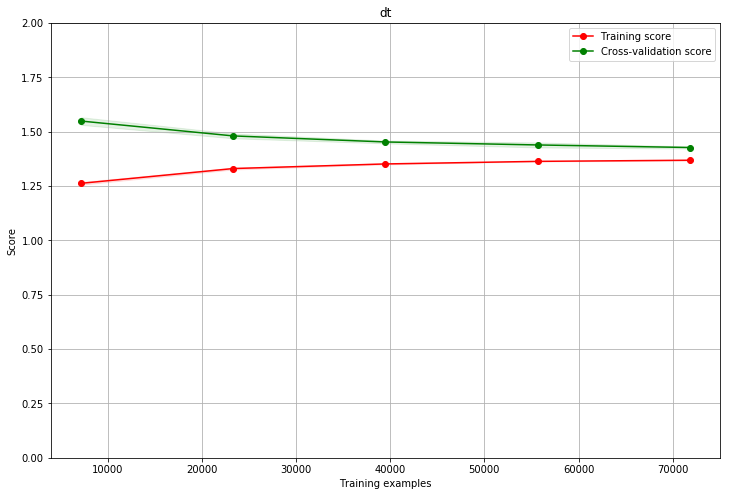

[RFR]: 1.6728959122799782 +/-0.006092771895742399


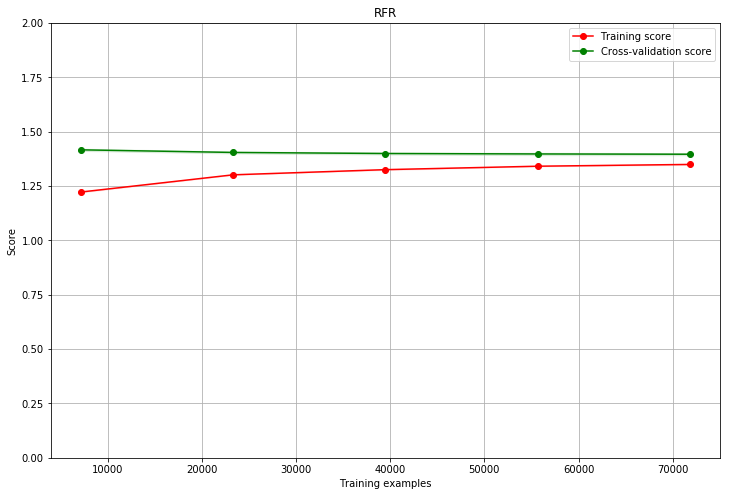

[Lgb]: 1.653157587897839 +/-0.004164826985618952


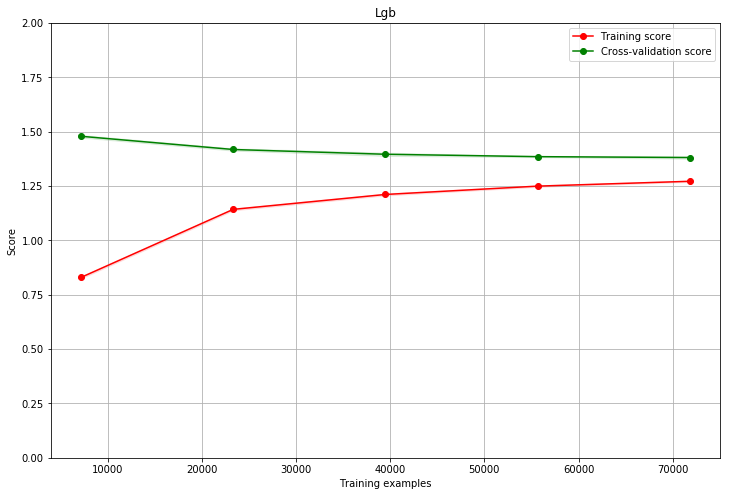

In [27]:
def get_models():
    md = 10
    ne = 100
    le=0.3
    rs = 2019
    nj = 8
    return [
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt', DecisionTreeRegressor(max_depth=md, random_state=rs)),
        ('RFR', RandomForestRegressor(max_depth=md, n_estimators = ne, random_state=rs)),
        ('Lgb', lgb.LGBMRegressor(max_depth=md, n_estimators = ne,  learning_rate = le, n_jobs=nj, random_state=rs)),
    ]

run(train.sample(frac=0.1), plot_lc=True, target_log=True)

New columns improved predicitons slightly [Lgb]: 1.657900378844894 +/-0.00727570995323309 vs [Lgb]: 1.653157587897839 +/-0.004164826985618952

# Is_cancelled prediction

Lets try to predicit whether plain will be cancel or not. Training data already has this information but this is information from the future so I should rather learn the model to tell if the plain will be cancelled or not. If yes, I will assign 4320 minutes of delay (which is max value of delay applied for all cancelled flights)

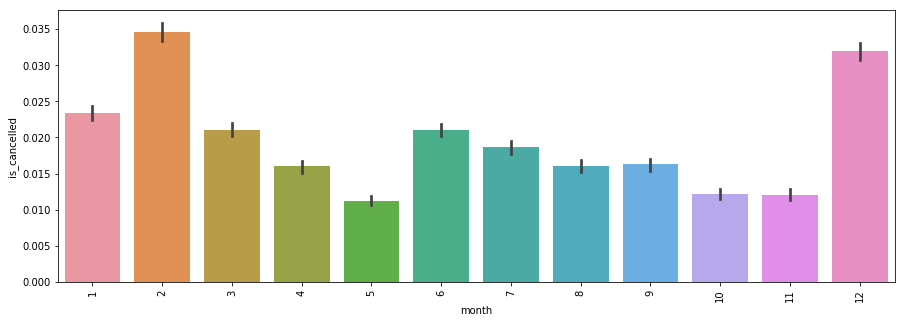

In [28]:
#lets check if months distribution is a good lead for canceletion prediction
plt.figure(figsize=(15, 5))
sns.barplot(x="month", y="is_cancelled", data=train)
plt.xticks(rotation=90);

February and December are months when cancellation is more probable

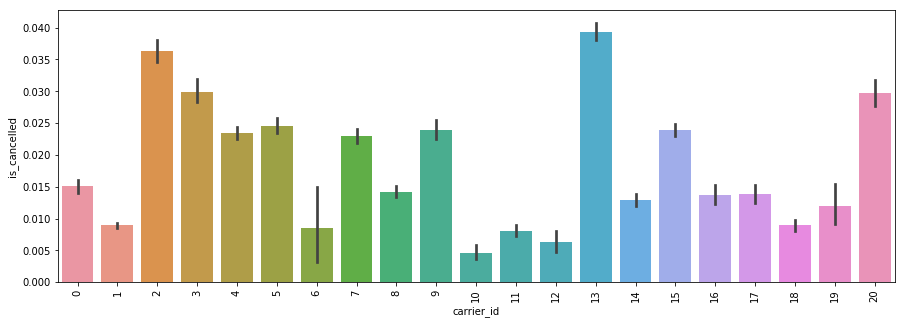

In [29]:
#lets check if any flight carriers are likely to have their flights cancelled
plt.figure(figsize=(15, 5))
sns.barplot(x='carrier_id', y="is_cancelled", data=train)
plt.xticks(rotation=90);

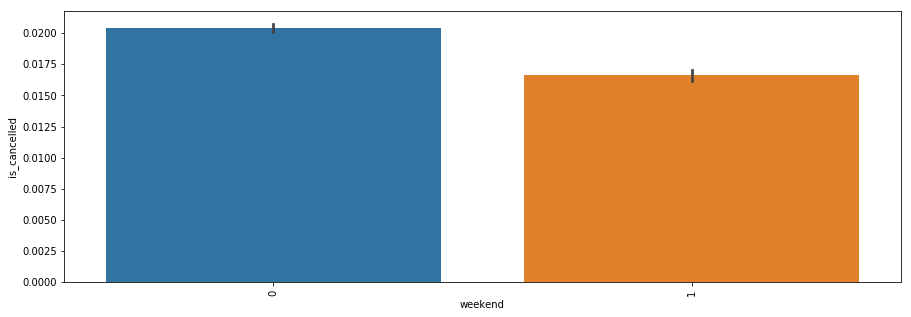

In [30]:
#Checking if weekend has anything to do with flight cancelletion
plt.figure(figsize=(15, 5))
sns.barplot(x='weekend', y="is_cancelled", data=train)
plt.xticks(rotation=90);

Diference is slight, doesn't look like a good lead

In [31]:
#lets group airports to regions
tz_dict = dict(zip(tz.code, tz.tz))
tz['tz_reg'] = tz['tz'].map(lambda x: x.split('/')[0])
tz['tz_reg_cat'] = tz['tz_reg'].factorize()[0]
tz_reg_dict = dict(zip(tz.code, tz.tz_reg_cat))

In [38]:
train['origin_reg_cat'] = train['origin'].map(lambda x: tz_reg_dict[x])
train['destination_reg_cat'] = train['destination'].map(lambda x: tz_reg_dict[x])
#transform is cancelled to int values
train["is_num_cancelled"] = train['is_cancelled'].map(lambda x:int(x))

Metric for cancelletion prediction should be precision, as I don't wish to penalize punctual flights

In [52]:
model = lgb.LGBMClassifier(max_depth = 5, n_estimators=50, learning_rate=0.3, n_jobs=8)
X = train[get_feats(train)]
y = train["is_num_cancelled"]
model.fit(X, y)



LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.3, max_depth=5,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=50, n_jobs=8, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
X = train[get_feats(train)]
train['is_canceled_pred'] = model.predict(X)
train['is_canceled_pred'].value_counts()

C:\Users\BSTN\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0    1056195
1      20919
Name: is_canceled_pred, dtype: int64

Once we predicted which flights are cancelled we can get rid of is_num canelled column

In [54]:
train.drop(['is_num_cancelled'], axis=1, inplace=True)

Now it's time for new iteration with predicted flight cancelation

In [56]:
get_feats(train)

['year',
 'month',
 'day_of_month',
 'day_of_week',
 'scheduled_departure_time',
 'scheduled_arrival_time',
 'carrier_id',
 'flight_number',
 'tail_number',
 'scheduled_elapsed_time',
 'distance',
 'weekend',
 'origin_cat',
 'destination_cat',
 'direction_cat',
 'origin_reg_cat',
 'destination_reg_cat',
 'is_canceled_pred']

[dummy_median]: 1.9917215405531152 +/-0.003734467690508232


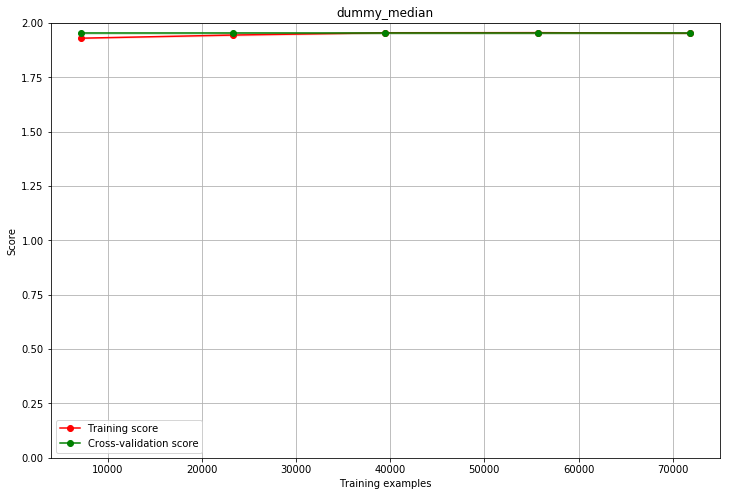

[dt]: 1.586465840766748 +/-0.0007285997941493276


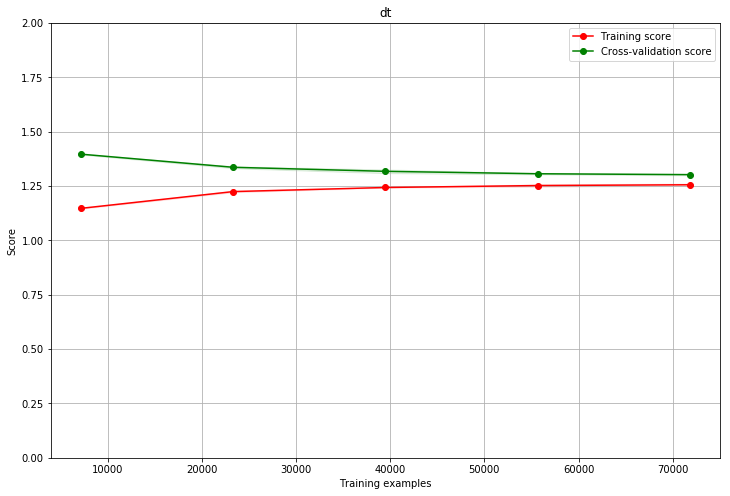

[RFR]: 1.5645128169133062 +/-0.003476806138219142


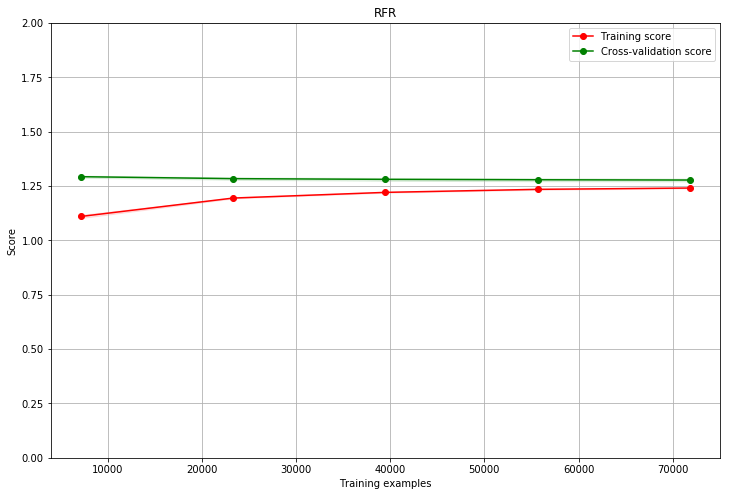

[Lgb]: 1.5472976820082565 +/-0.0026425099038011176


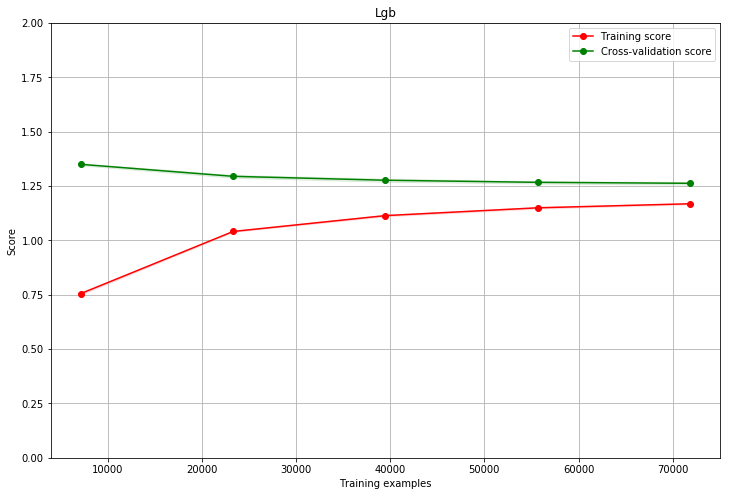

In [57]:
def get_models():
    md = 10
    ne = 100
    le=0.3
    rs = 2019
    return [
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt', DecisionTreeRegressor(max_depth=md, random_state=rs)),
        ('RFR', RandomForestRegressor(max_depth=md, n_estimators = ne, random_state=rs)),
        ('Lgb', lgb.LGBMRegressor(max_depth=md, n_estimators = ne,  learning_rate = le, random_state=rs)),
    ]

run(train.sample(frac=0.1), plot_lc=True, target_log=True)

Predicting value from the future (is_cancelled) decreased RMSLE to 1.54 (vs 1.6531 from the last iteration).

Again, LightGBM is the best model for this regression task. Final metric can be improved by hyperparameter optimization.